In [1]:
#DATA OVERVIEW

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

df = pd.read_csv('ncr_ride_bookings.csv')

# Set visualisation style
sns.set(style='whitegrid', palette='muted', color_codes=True)
sns.set_context("notebook") # readable sizing

# Set a custom color palette to use across plots
main_palette = sns.color_palette("Set2")
sns.set_palette(main_palette)

def save_and_show_plot(filename, folder="plots"):
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    plt.show()


print(df.head())

         Date      Time    Booking ID   Booking Status   Customer ID  \
0  2024-03-23  12:29:38  "CNR5884300"  No Driver Found  "CID1982111"   
1  2024-11-29  18:01:39  "CNR1326809"       Incomplete  "CID4604802"   
2  2024-08-23  08:56:10  "CNR8494506"        Completed  "CID9202816"   
3  2024-10-21  17:17:25  "CNR8906825"        Completed  "CID2610914"   
4  2024-09-16  22:08:00  "CNR1950162"        Completed  "CID9933542"   

    Vehicle Type      Pickup Location      Drop Location  Avg VTAT  Avg CTAT  \
0          eBike          Palam Vihar            Jhilmil       NaN       NaN   
1       Go Sedan        Shastri Nagar  Gurgaon Sector 56       4.9      14.0   
2           Auto              Khandsa      Malviya Nagar      13.4      25.8   
3  Premier Sedan  Central Secretariat           Inderlok      13.1      28.5   
4           Bike     Ghitorni Village        Khan Market       5.3      19.6   

   ...  Reason for cancelling by Customer Cancelled Rides by Driver  \
0  ...         

In [2]:
# Shape of the dataset
df.shape

(150000, 21)

In [3]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

In [4]:
#DATA CLEANING

# Check duplicated values
df.duplicated().sum()

np.int64(0)

In [5]:
# Check missing values
df.isna().sum()

Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
dtype: int64

In [6]:
threshold = len(df) * 0.05  # 5% missing allowed

# Boolean mask for columns with >0 missing and <= threshold
mask = (df.isna().sum() > 0) & (df.isna().sum() <= threshold)

# Select only those column names
cols_to_drop = df.columns[mask]

print(cols_to_drop)


Index([], dtype='object')


Dropping entire columns is not an ideal approach to handle missing values, especially when the proportion of missing data exceeds the 5% threshold. Instead, a tailored strategy for managing missing data is outlined in the table below.

| Column                       | Missingness Type | Strategy for Handling          | Rationale                                           |
|--------------------------------|------------------|----------------------------|-------------------------------------------------------|
| Avg VTAT                       | MAR              | Fill with median           | Right-skewed distribution, avoids impact of outliers  |
| Avg CTAT                       | MAR              | Fill with median           | Left-skewed distribution, avoids impact of outliers   |
| Booking Value                  | MAR              | Fill with median           | Right-skewed distribution, median preserves central tendency |
| Ride Distance                  | MAR              | Fill with median           |Preserve the effect of extreme values              |
| Driver Ratings                 | MAR              | Fill with mean             | Ratings tend to cluster; mean gives representative value |
| Customer Rating                | MAR              | Fill with mean             | Ratings tend to cluster; mean gives representative value |
| Payment Method                 | MAR              | Fill with mode             | Categorical feature, most common payment type is reasonable |
| Cancelled Rides by Customer    | MNAR             | Fill with 0                | Missing implies ride was not cancelled by customer       |
| Reason for Cancelling by Customer| MNAR            | Fill with "None"           | Applies only when a cancellation occurred                |
| Cancelled Rides by Driver      | MNAR             | Fill with 0                | Applies only when a cancellation occurred                |
| Driver Cancellation Reason     | MNAR             | Fill with "None"           | Reason is only available if cancelled                    |
| Incomplete Rides               | MNAR             | Fill with 0                | Missing implies ride was completed                       |
| Incomplete Rides Reason        | MNAR             | Fill with "None"           | Applies only when a ride is incomplete                   |


In [7]:
# Fill numerical values
df['Avg VTAT'] = df['Avg VTAT'].fillna(df['Avg VTAT'].median())
df['Avg CTAT'] = df['Avg CTAT'].fillna(df['Avg CTAT'].median())
df['Booking Value'] = df['Booking Value'].fillna(df['Booking Value'].median())
df['Ride Distance'] = df['Ride Distance'].fillna(df['Ride Distance'].median())
df['Driver Ratings'] = df['Driver Ratings'].fillna(df['Driver Ratings'].mean())
df['Customer Rating'] = df['Customer Rating'].fillna(df['Customer Rating'].mean())

# Fill categorical value - MAR
df['Payment Method'] = df['Payment Method'].fillna(df['Payment Method'].mode()[0])

# Fill MNAR values
cols_to_fill = [
    'Cancelled Rides by Customer',
    'Reason for cancelling by Customer',
    'Cancelled Rides by Driver',
    'Driver Cancellation Reason',
    'Incomplete Rides',
    'Incomplete Rides Reason'
]

for col in cols_to_fill:
    if col in df.columns:  # prevents KeyError
        if df[col].dtype == 'O':  # categorical/text
            df[col] = df[col].fillna('None')
        else:  # numeric
            df[col] = df[col].fillna(0)

In [8]:
# Check the missing values again
df.isna().sum()

Date                                 0
Time                                 0
Booking ID                           0
Booking Status                       0
Customer ID                          0
Vehicle Type                         0
Pickup Location                      0
Drop Location                        0
Avg VTAT                             0
Avg CTAT                             0
Cancelled Rides by Customer          0
Reason for cancelling by Customer    0
Cancelled Rides by Driver            0
Driver Cancellation Reason           0
Incomplete Rides                     0
Incomplete Rides Reason              0
Booking Value                        0
Ride Distance                        0
Driver Ratings                       0
Customer Rating                      0
Payment Method                       0
dtype: int64

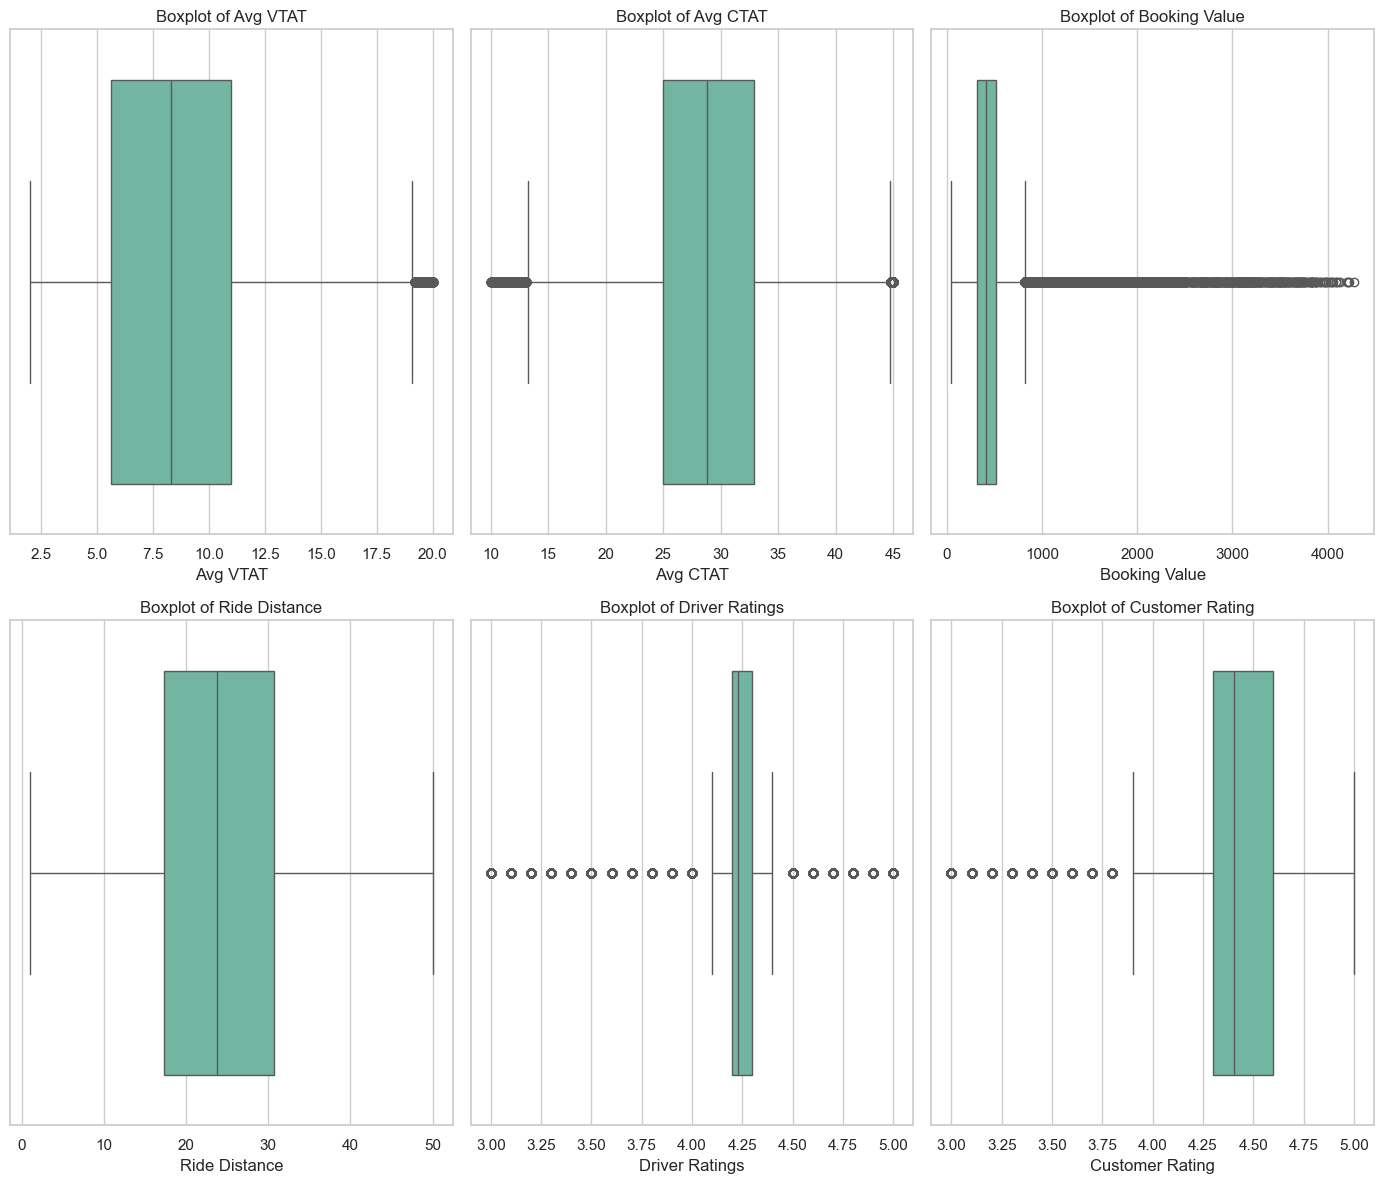

In [9]:
num_cols = [
    'Avg VTAT',
    'Avg CTAT',
    'Booking Value',
    'Ride Distance',
    'Driver Ratings',
    'Customer Rating'
]

plt.figure(figsize=(14,12))

for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()

plt.show()


Observation: Outliers are present in all numeric columns except Ride Distance.

In [10]:
# Check outliers
outliers = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    iqr = Q3 - Q1
    lower_threshold = Q1 - 1.5 * iqr
    upper_threshold = Q3 + 1.5 * iqr

    outlier_indices = df[(df[col] < lower_threshold) | (df[col] > upper_threshold)].index
    outliers[col] = outlier_indices.tolist()

for col, inds in outliers.items():
    print(f"{col}: {len(inds)} outliers")

Avg VTAT: 631 outliers
Avg CTAT: 2187 outliers
Booking Value: 17332 outliers
Ride Distance: 0 outliers
Driver Ratings: 51094 outliers
Customer Rating: 10533 outliers


| Column          | Handling Approach                    | Justification                   |
|-----------------|--------------------------------------|---------------------------------|
| Avg VTAT        | Cap at 99th percentile               | Long delays can distort averages, capping reduces impact while keeping data trends |
| Avg CTAT        | Cap at 99th percentile               | Same as Avg VTAT                |
| Booking Value   | Cap at 99th percentile               | Extremely high fares are rare cases that could skew revenue analysis |
| Driver Ratings  | Retain without changes               | Rating extremes (1–5) are valid and represent genuine user opinions |
| Customer Rating | Retain without changes               | Same as Driver Ratings          |


In [11]:
# Handling outliers
cols_to_cap = [
    'Avg VTAT',
    'Avg CTAT',
    'Booking Value'
]

for col in cols_to_cap:
    lower = df[col].quantile(0.01)   # 1st percentile
    upper = df[col].quantile(0.99)   # 99th percentile
    df[col] = df[col].clip(lower=lower, upper=upper)


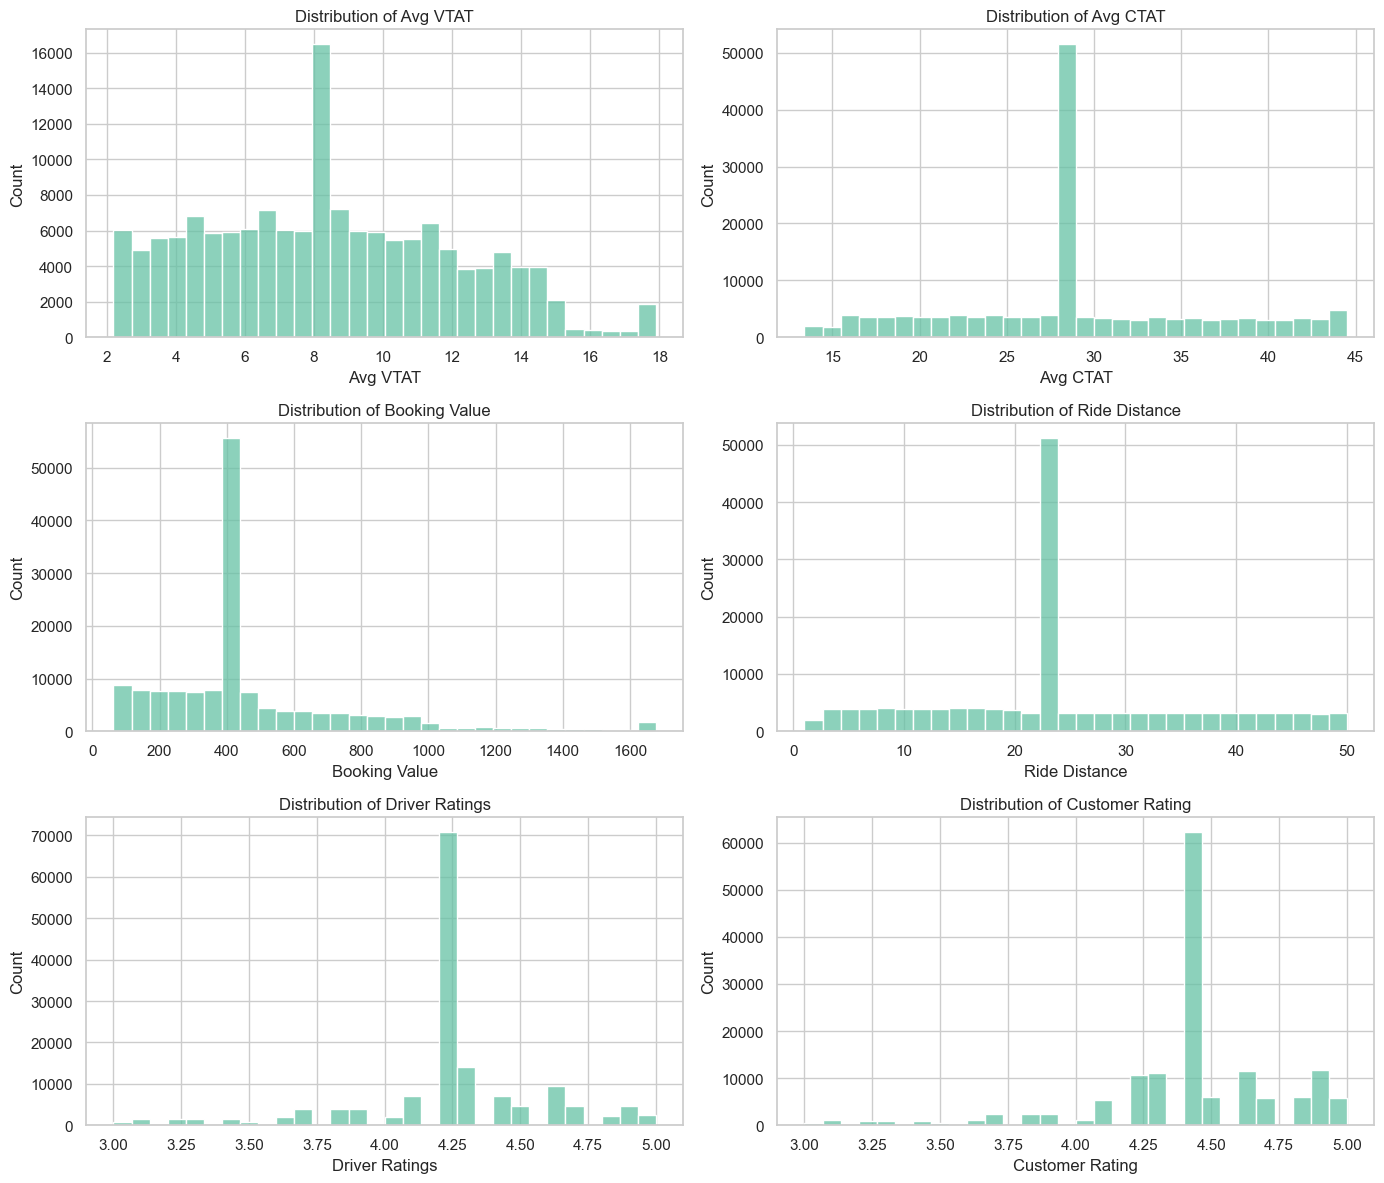

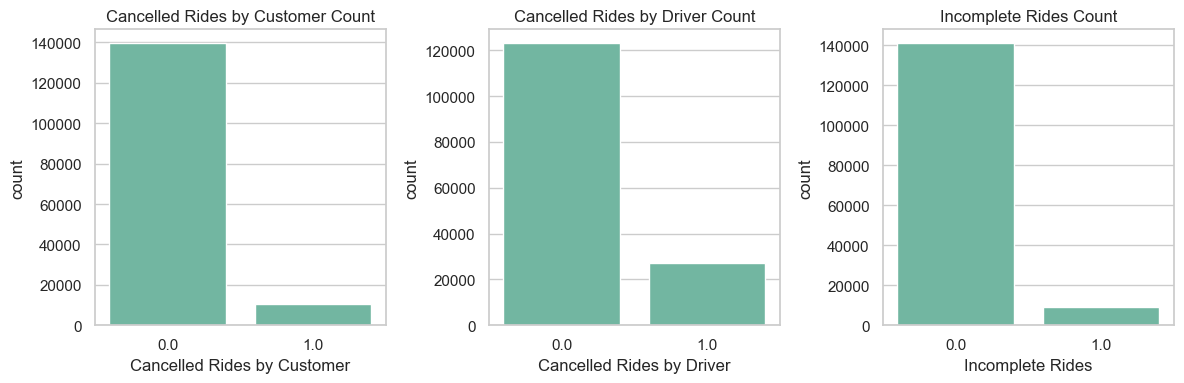

In [12]:
# EDA

# Numerical values
# Separate numerical columns to binary and non-binary values
bin_cols = [
    'Cancelled Rides by Customer',
    'Cancelled Rides by Driver',
    'Incomplete Rides'
]

# Histogram for numerical (non-binary) columns
plt.figure(figsize=(14,12))
for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=df[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.tight_layout()
plt.show()

# Count plots for binary columns
plt.figure(figsize=(12, 4))
for i, col in enumerate(bin_cols):
    plt.subplot(1,3, i+1)
    sns.countplot(x=col, data=df)
    plt.title(f"{col} Count")
plt.tight_layout()
plt.show()

**Interpretation:**

- **Avg VTAT** and **Booking Value** are right-skewed, possibly suggesting quick service and affordable rides, but outliers suggest occasional delays or premium trips.
- The distribution of **Avg CTAT** and **Ride Distance** is generally uniformed -> The platform serves a wide variety of trip types, from short to long rides, without clear dominance of a single category.
- **Driver Ratings and Customer Rating** are left-skewed, indicating strong satisfaction levels among both drivers and riders, a positive sign for trust and platform loyalty.
- **Customer cancellations** are low → riders are generally committed.
- **Driver cancellations** are notably higher → root causes (low incentives, mismatched pickup distances, system inefficiencies) should be investigated.
- **Incomplete rides**, though rare, require attention → may indicate deeper operational or service quality problems.

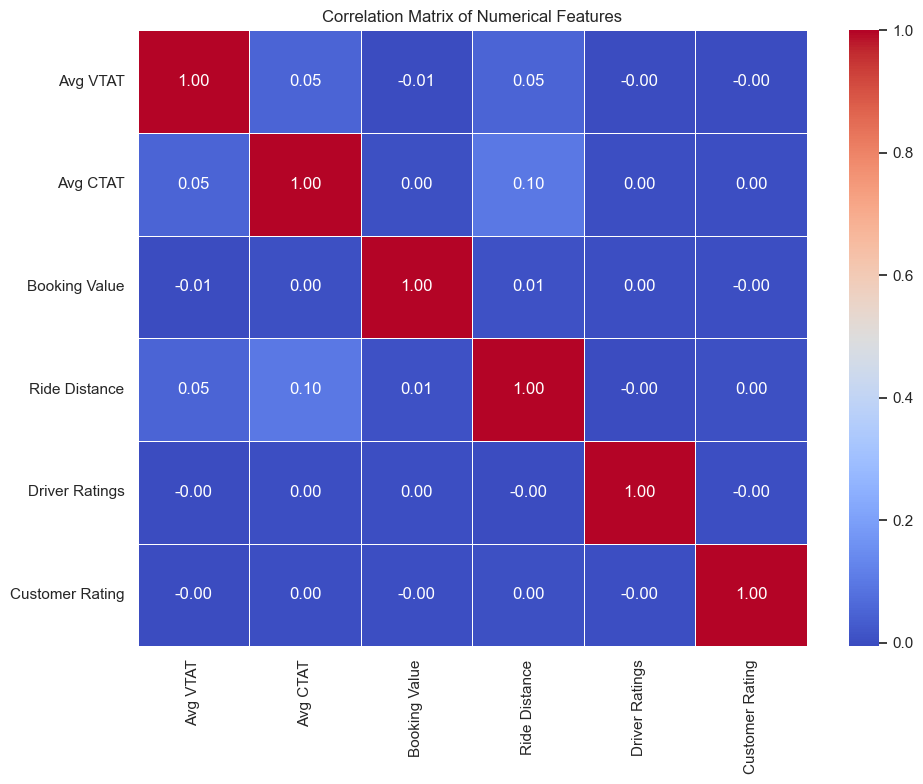

In [13]:
# Pair plot to investigate relationships between numerical values
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

**Interpretation:**

- This chart reveals that key business metrics like ride distance, booking value, and ratings do not directly influence each other, as even the strongest relationship shown—between Ride Distance and wait time—is a statistically negligible 0.10.

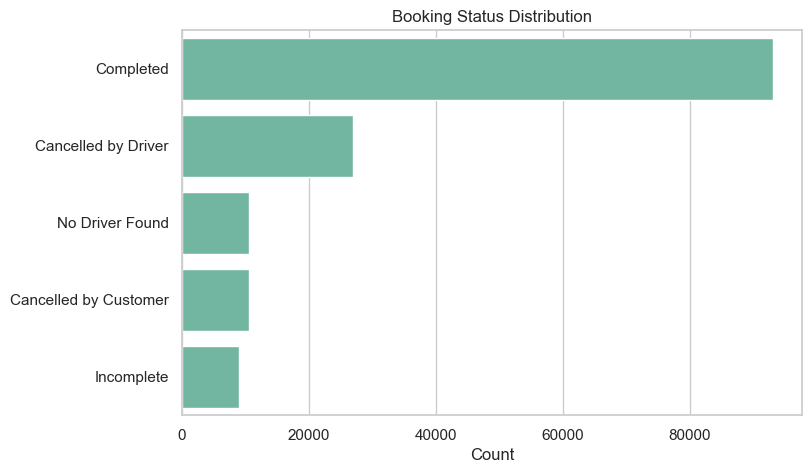

<Figure size 640x480 with 0 Axes>

In [14]:
# Booking Status Analysis

# Exclude 'None'
filtered_df = df[df['Booking Status'] != 'None']

# Get counts and sort
order = filtered_df['Booking Status'].value_counts().sort_values(ascending=False).index

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=filtered_df, y='Booking Status', order=order)

plt.title("Booking Status Distribution")
plt.xlabel("Count")
plt.ylabel("")
plt.show()

save_and_show_plot("booking_status.png")


**Interpretation:**

- The majority of the **booking status** is completed.
- Auto, Go Mini and Go Sedan dominated the vehicle type.
- **Cancellation reasons:**
    - Customer cancellations are mainly due to input errors or changes in plans (e.g., wrong address, change of plans), along with frustration when the driver doesn’t move toward the pickup. These are more customer-side behaviours than driver-related issues.
    - Driver cancellations mostly stem from safety, health, or personal constraints (e.g., too many passengers, sick customers, personal/car issues), which seem consistent across the data.
    - Across both groups, a small number of recurring reasons dominate cancellations, suggesting that targeted fixes (e.g., better address validation in the app, clearer communication of driver policies) could significantly reduce cancellation rates.  
- UPI is the most preferred payment method, suggesting digital payments are well-adopted, indicating trust and convenience.
- **Incomplete rides:**
    - Customer Demand is the most common cause of incomplete rides, suggesting ride interruptions often happen at the rider’s request (e.g., change of destination, early drop-off).
    - Vehicle Breakdown is almost equally significant, pointing to operational reliability issues that may require stronger vehicle maintenance checks.

In [15]:
# Ride Patterns

# Convert date and time
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time

df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

# Extract day, month and hour from date and time 
df['Weekday'] = df['Datetime'].dt.day_name()
df['Month'] = df['Datetime'].dt.month
df['Hour'] = df['Datetime'].dt.hour

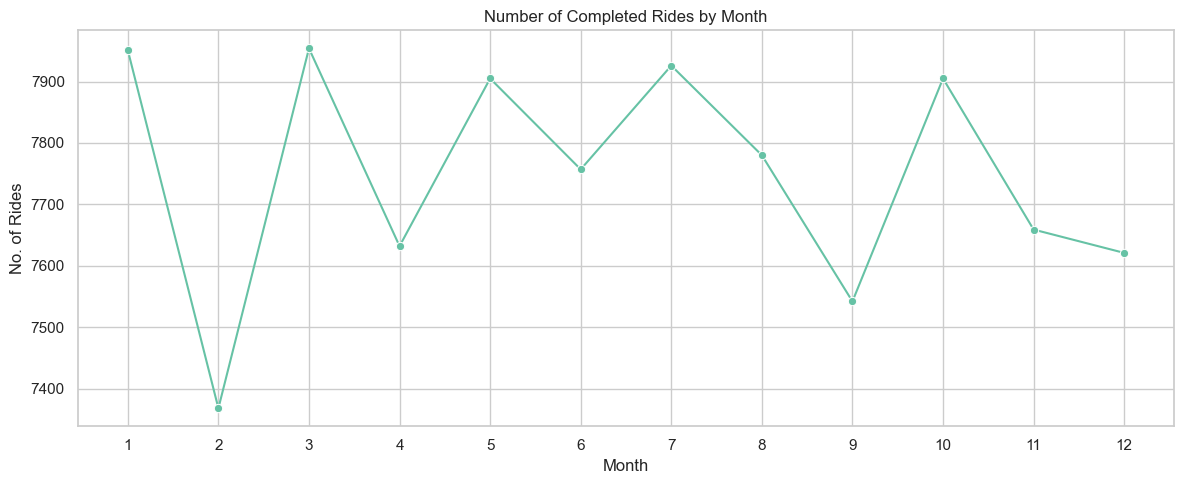

In [16]:
# Completed rides by Month
completed = df[df['Booking Status'] == 'Completed']

# Count rides per month
monthly_completed = completed.groupby('Month').size().reset_index(name='Count')

monthly_completed = monthly_completed.sort_values('Month')

plt.figure(figsize=(12,5))
sns.lineplot(x='Month', y='Count', data=monthly_completed, marker="o")
plt.xticks(ticks=monthly_completed['Month'].unique())
plt.title("Number of Completed Rides by Month")
plt.xlabel("Month")
plt.ylabel("No. of Rides")
plt.tight_layout()
plt.show()


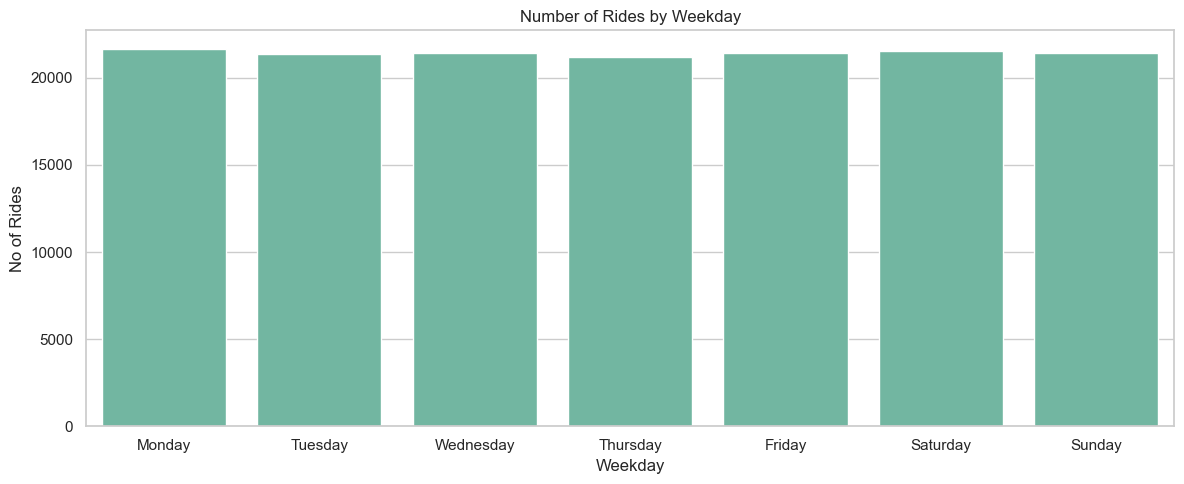

In [17]:
# Number of rides by weekday

plt.figure(figsize=(12,5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='Weekday', data=df, order=order)
plt.title('Number of Rides by Weekday')
plt.xlabel('Weekday')
plt.ylabel('No of Rides')
plt.tight_layout()
plt.show()

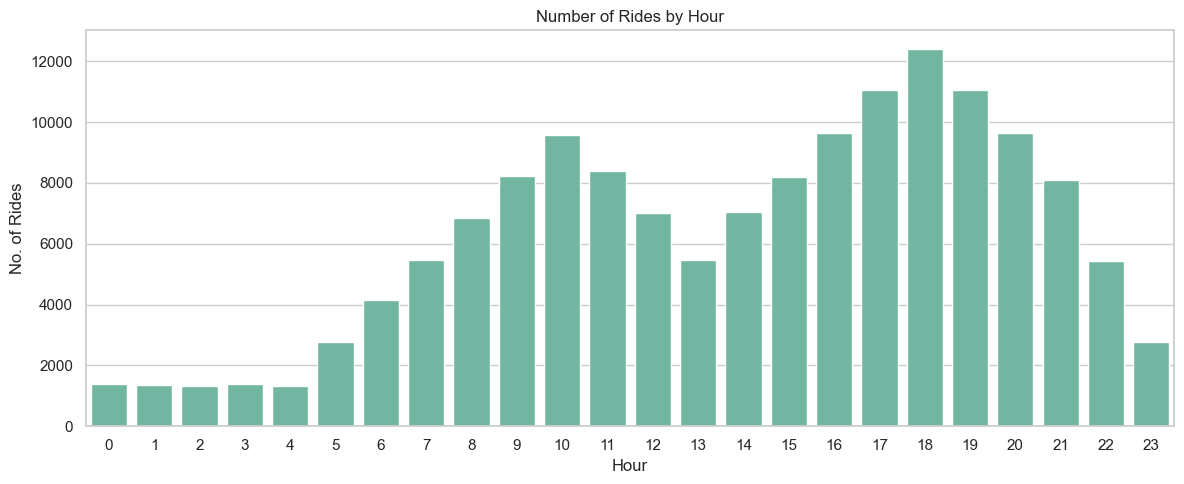

<Figure size 640x480 with 0 Axes>

In [18]:
# Number of rides by hour

plt.figure(figsize=(12,5))
sns.countplot(x='Hour', data=df, order=sorted(df['Hour'].dropna().unique()))
plt.title("Number of Rides by Hour")
plt.xlabel("Hour")
plt.ylabel("No. of Rides")
plt.tight_layout()
plt.show()

save_and_show_plot("hourly_demand.png")

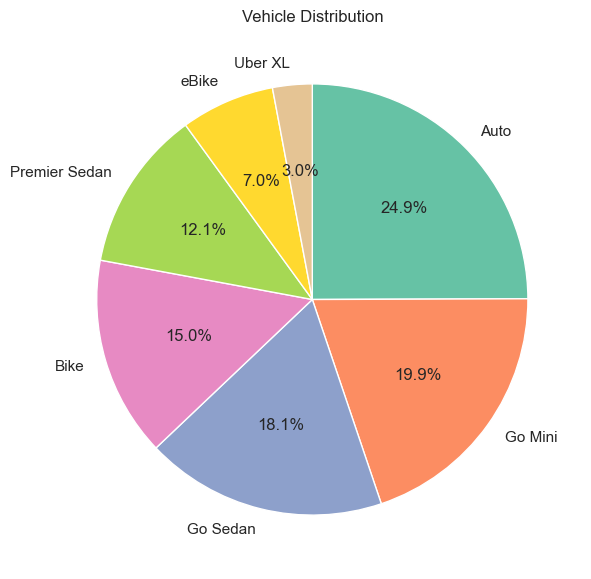

In [19]:
#Vehicle popularity

# Count each vehicle type
vehicle_counts = df['Vehicle Type'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    vehicle_counts, 
    labels=vehicle_counts.index, 
    autopct='%1.1f%%',   # show percentages
    startangle=90,       # rotate for better orientation
    counterclock=False   # clockwise direction
)

plt.title('Vehicle Distribution')
plt.show()

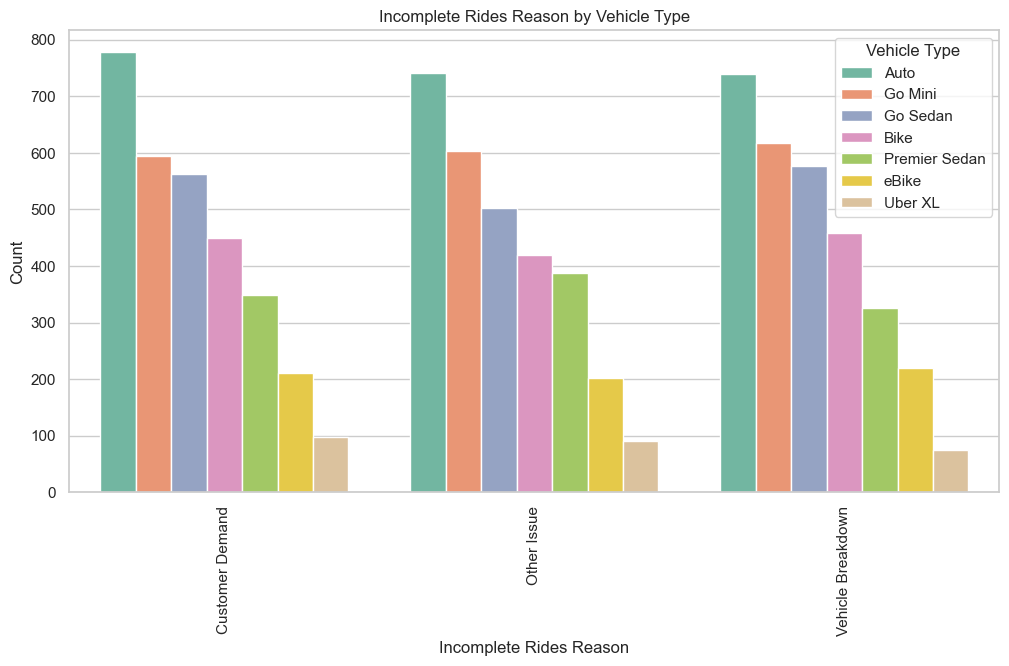

In [20]:
# Incomplete rides by vehicle type
count_incomplete = df.groupby(['Vehicle Type', 'Incomplete Rides Reason']).size().reset_index(name='Count')

# Exclude 'None' Reason
count_incomplete = count_incomplete[count_incomplete['Incomplete Rides Reason'] != 'None']
count_incomplete = count_incomplete.sort_values('Count',ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x='Incomplete Rides Reason',y='Count',hue='Vehicle Type', data=count_incomplete)
plt.title('Incomplete Rides Reason by Vehicle Type')
plt.xticks(rotation=90)
plt.show()

**Interpretation:**

- **Monthly Rides:** Ride demand is highly volatile from month to month, with significant peaks and dips (like a major drop in February), indicating a strong seasonal effect that requires flexible marketing and driver management.
- **Weekday Rides:** Business is remarkably consistent across all seven days of the week, meaning driver supply and operational resources can be planned evenly without worrying about a "weekend rush" or "mid-week slump."
- **Hourly Rides:** The day is defined by two distinct rush hours, with the evening peak (4 PM - 9 PM) being significantly busier than the morning commute, making it the most critical time for managing pricing and ensuring enough drivers are on the road.
- **Vehicle Distribution:** Auto is the most popular vehicle choice at nearly 25%, with Go Mini and Go Sedan following closely behind, and together these three categories account for almost two-thirds of all rides.
- **Incomplete Rides:**
    - **Autos** contribute the largest share of incomplete rides, which is consistent with their overall dominance in bookings.
    - Smaller categories (like Uber XL, eBike, Premier Sedan) show relatively low incomplete ride counts.
    - **Incomplete ride reasons** are fairly balanced across categories — there is no one overwhelming root cause.

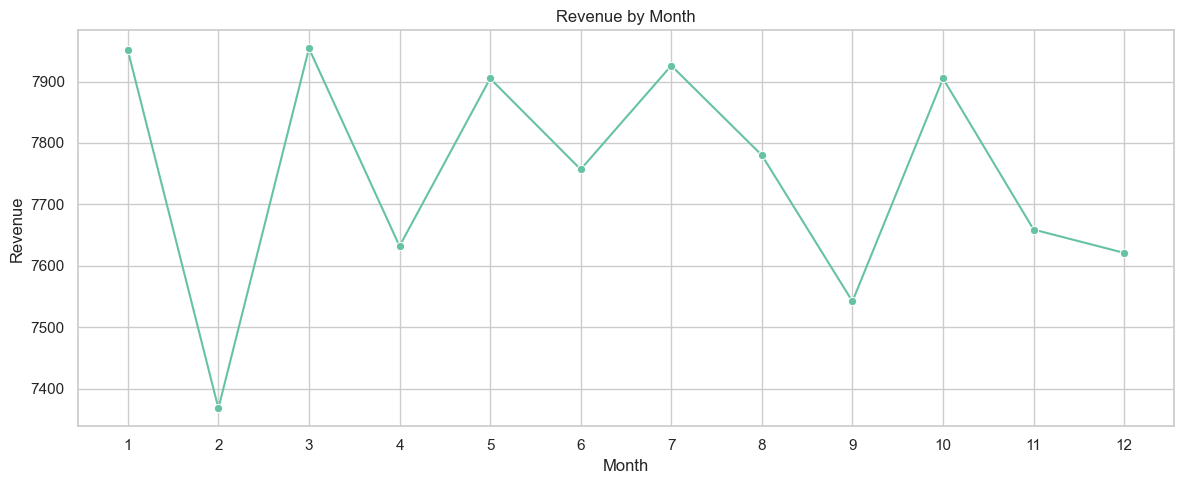

In [21]:
# Revenue by Month

revenue = completed.groupby('Month')['Booking Value'].sum().reset_index(name='Count')

monthly_completed = monthly_completed.sort_values('Month')

plt.figure(figsize=(12,5))
sns.lineplot(x='Month', y='Count', data=monthly_completed, marker="o")
plt.xticks(ticks=monthly_completed['Month'].unique())
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


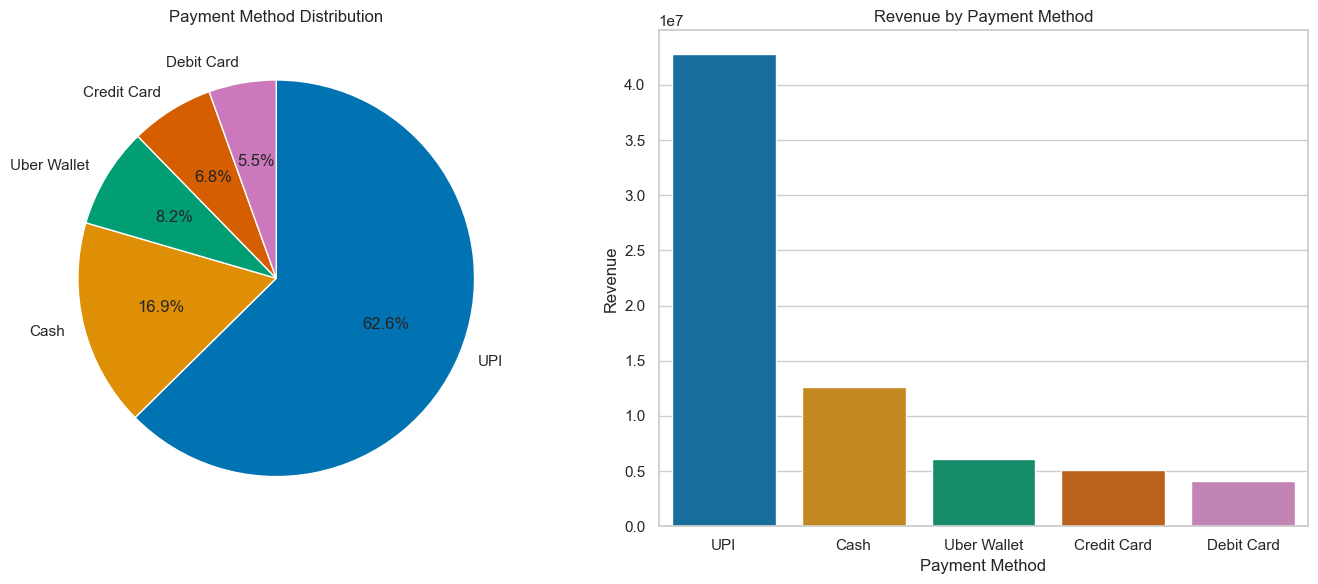

In [22]:
# Count each payment method type
payment_counts = df[df['Payment Method'] != 'None']['Payment Method'].value_counts()
revenue_by_payment = (
    df[df['Payment Method'] != 'None']
    .groupby('Payment Method')['Booking Value']
    .sum()
    .sort_values(ascending=False)   # sort by revenue
)

# Define consistent colors
colors = sns.color_palette("colorblind", len(payment_counts))
color_map = dict(zip(payment_counts.index, colors))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie chart ---
axes[0].pie(
    payment_counts, 
    labels=payment_counts.index, 
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=[color_map[method] for method in payment_counts.index]
)
axes[0].set_title('Payment Method Distribution')

# --- Bar chart (sorted by revenue) ---
sns.barplot(
    x=revenue_by_payment.index,
    y=revenue_by_payment.values,
    hue=revenue_by_payment.index, 
    palette=color_map,
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Revenue by Payment Method')
axes[1].set_xlabel('Payment Method')
axes[1].set_ylabel('Revenue')

plt.tight_layout()
plt.show()


**Interpretation:**

- Revenue by month fluctuates in line with completed rides → this suggests that seasonal demand is the main driver of revenue.
- UPI dominates as the payment method → customers clearly prefer fast, cashless, and convenient payments, which also reduces operational risks tied to cash handling.
- Consistent transaction value across payment methods → since revenue is proportional to usage frequency, the average fare per ride is stable, meaning pricing is not influenced by payment choice.

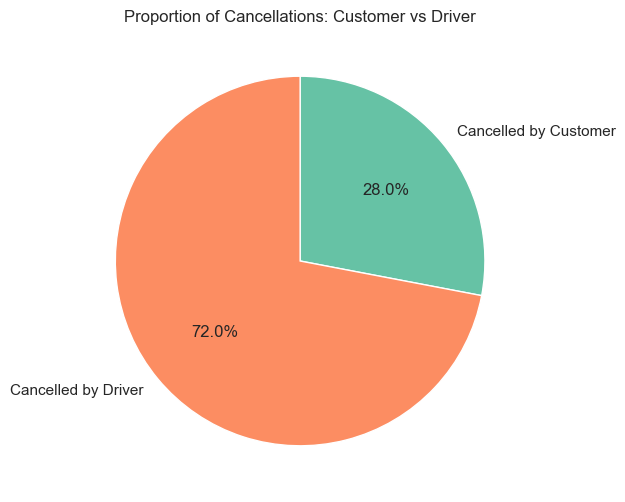

In [23]:
# Sum cancellations
cancel_counts = {
    'Cancelled by Customer': df['Cancelled Rides by Customer'].sum(),
    'Cancelled by Driver': df['Cancelled Rides by Driver'].sum()
}

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    cancel_counts.values(),
    labels=cancel_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=sns.color_palette("Set2")
)
plt.title("Proportion of Cancellations: Customer vs Driver")
plt.show()


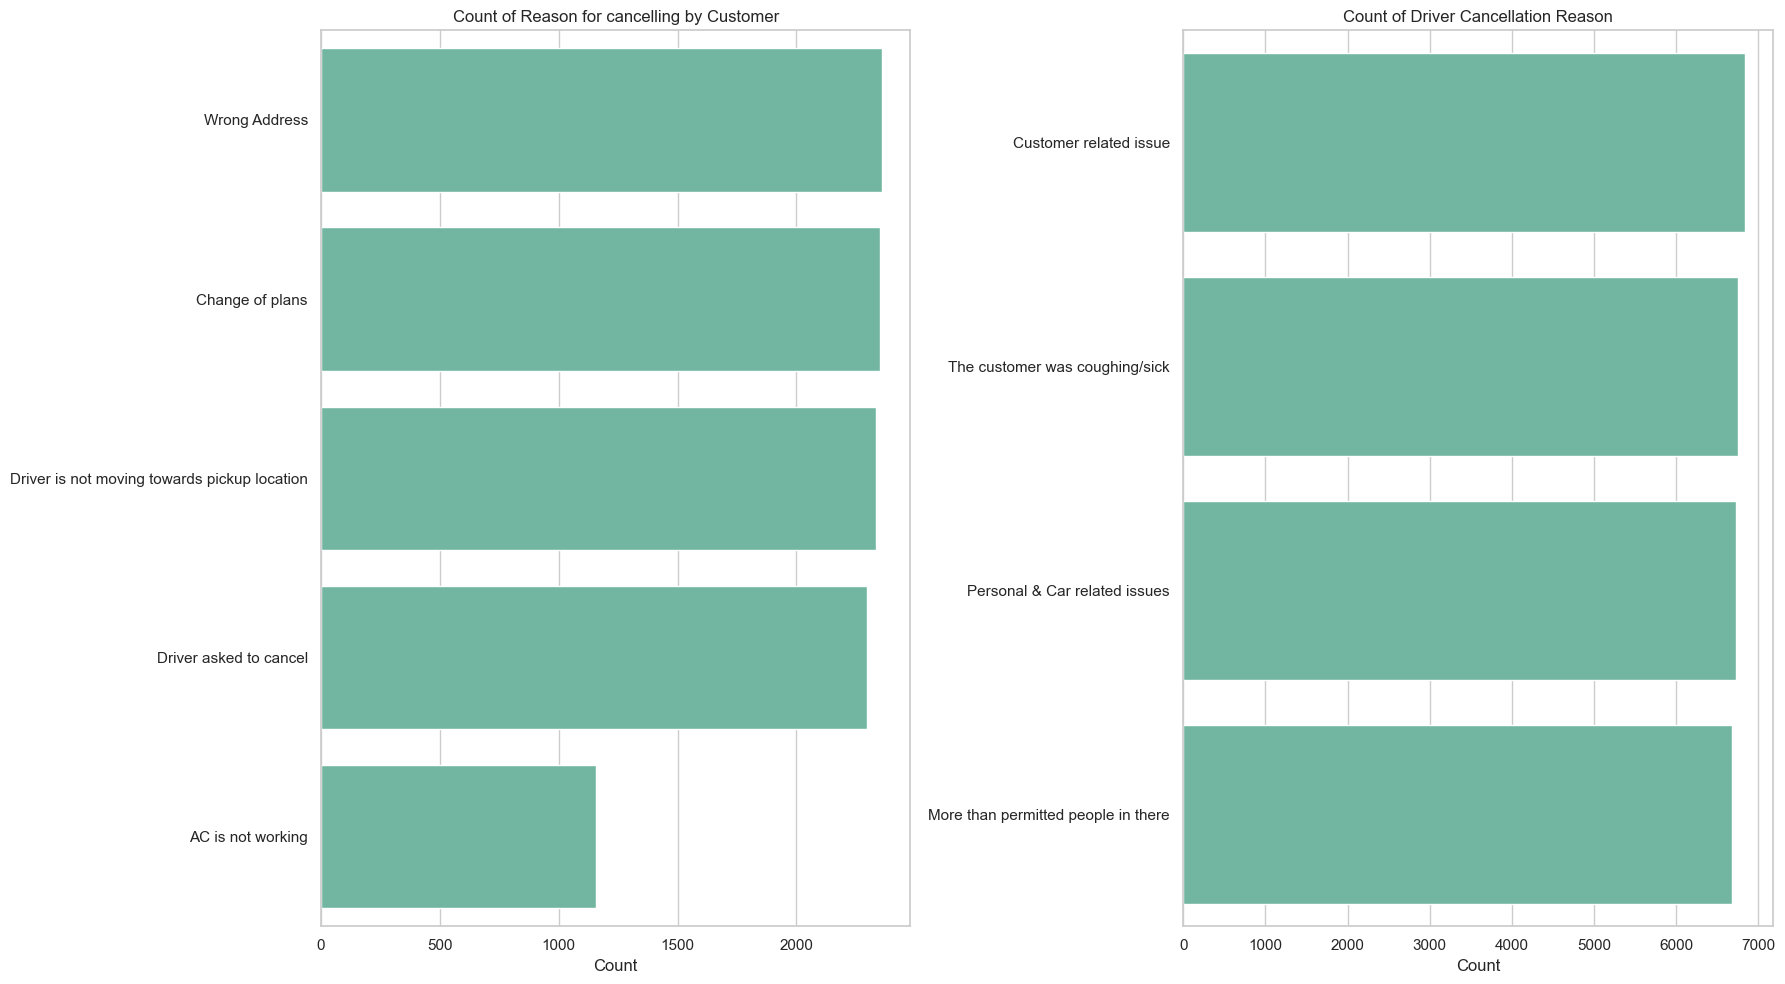

<Figure size 640x480 with 0 Axes>

In [24]:
# Reasons for cancellation
reason_cols = [
    'Reason for cancelling by Customer',
    'Driver Cancellation Reason'
]

# Plot
plt.figure(figsize=(18, 10))

for i, col in enumerate(reason_cols, 1):
    plt.subplot(1, 2, i)
    
    # Filter out 'None'
    filtered_df = df[df[col] != 'None']
    
    # Count categories and sort descending
    order = filtered_df[col].value_counts().index
    
    sns.countplot(
        data=filtered_df,
        y=col,
        order=order,
        legend=False      
    )
    
    plt.title(f"Count of {col}")
    plt.xlabel('Count')
    plt.ylabel('')

plt.tight_layout()
plt.show()

save_and_show_plot("cancellations.png")

**Interpretation:**

- Drivers cancelled more frequently than customers (72% of cancellations), suggesting that addressing driver-related issues could have a larger overall impact on reducing incomplete rides.
- **Cancellation reasons:**
    - Customer cancellations are mainly due to input errors or changes in plans (e.g., wrong address, change of plans), along with frustration when the driver doesn’t move toward the pickup. These are more customer-side behaviours than driver-related issues.
    - Driver cancellations mostly stem from safety, health, or personal constraints (e.g., too many passengers, sick customers, personal/car issues), which seem consistent across the data.
    - Across both groups, a small number of recurring reasons dominate cancellations, suggesting that targeted fixes (e.g., better address validation in the app, clearer communication of driver policies) could significantly reduce cancellation rates.  

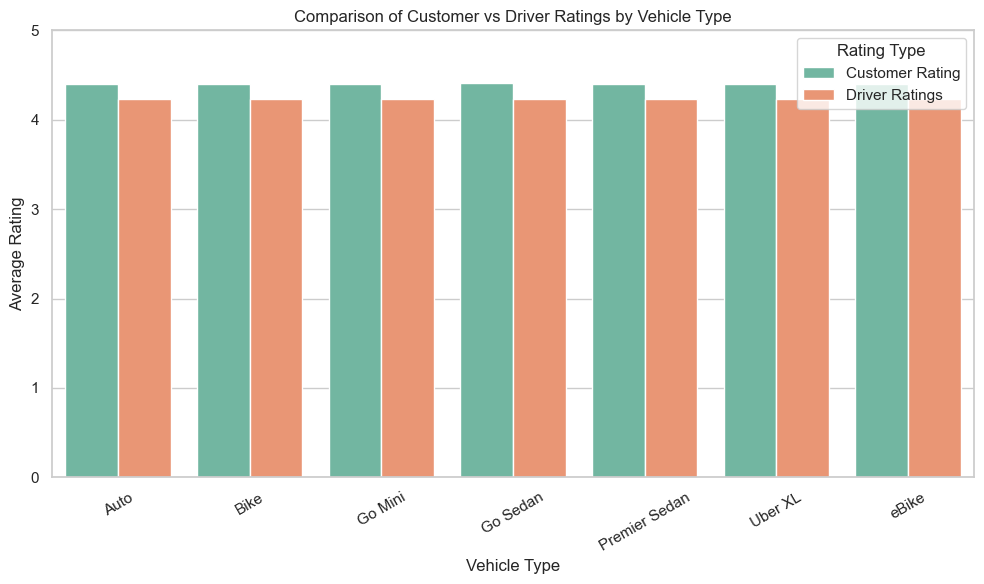

In [25]:
# Group data by vehicle type and take mean ratings
rating_comparison = df.groupby("Vehicle Type")[["Customer Rating", "Driver Ratings"]].mean().reset_index()

# Melt into long format for seaborn
rating_melted = rating_comparison.melt(id_vars="Vehicle Type", 
                                       value_vars=["Customer Rating", "Driver Ratings"], 
                                       var_name="Rating Type", 
                                       value_name="Average Rating")

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=rating_melted, x="Vehicle Type", y="Average Rating", hue="Rating Type")

plt.title("Comparison of Customer vs Driver Ratings by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Average Rating")
plt.ylim(0, 5)  # ratings are usually 0-5 scale
plt.legend(title="Rating Type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


**Interpretation:**
- **Consistent High Quality:** The service is consistently high-quality, with both customers and drivers giving high average ratings (above 4.2) regardless of the vehicle type used, indicating that the core experience is reliable across the entire fleet.
- **Minor Driver Satisfaction Gap:** Despite the high scores, a consistent pattern shows customer ratings are always slightly higher than driver ratings, suggesting a minor but persistent friction in the driver's experience that warrants investigation to ensure long-term driver retention.

**Conclusion**

**Key Takeaways:**
- **Seasonal & time-based demand:** Ride demand fluctuates strongly month-to-month but stays stready across weekdays; peak hours (esp. evenings) drive the highest volume.
- **High satisfaction levels:** Both customers and driveres give consistently high ratings (4.2+), though a silght gap exists where drivers are lower.
- **Cancellations impact reliability:** Driver cancellations (72%) far exceed customer cancellations, making them the largest source of lost rides.
- **Incomplete rides rare but notable:** Mostly caused by customer requests or vehicle breakdowns, with Autos contributing the largest share.
- **Digital payments dominate:** UPI is the most preferred payment method, showing strong trust and adoption of cashless transactions.

**Business Recommendations:**
- **Manage peak demand:** Use targeted driver incentives and dynamic pricing during evening rush hours and seasonal dips.
- **Reduce driver cancellations:** Address pickup inefficiencies, adjust incentive structures, strengthen driver support/safety measures.
- **Enhance customer experience:** Improve address validation and add better in-app communication to minimise input errors and impatience-driven cancellations.
- **Improve operational reliability:** Introduce stronger vehicle maintenance programs, especially for Autos, to reduce breakdown-related incomplete rides.
- **Leverage digital adoption:** Promote UPI further with loyalty rewards/cashbacks while ensuring seamless payment experiences.